## Assignment 3
In this assignment, I was given a binomial model for a stock. I was required to use Gradient policy Method to train the optimal policy for hedging an ATM European call option. I can choose any fraction of the stock.

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

Firstly, I create a class named price to generate binomial model for the stock price and option price.

In [2]:
class price():
    def __init__(self, n, T, volatility, r, initial_price):
        self.n = n
        deltaT = T/n
        self.u = np.exp(volatility*np.sqrt(deltaT))
        self.d = 1/self.u
        self.p = (np.exp(r*deltaT) - self.d)/(self.u - self.d)
        self.discount = np.exp(-r*deltaT)
        self.stock_price = dict()
        self.stock_price[(1, 0)] = [initial_price, self.u*initial_price, self.d*initial_price]
        self.initial_price = initial_price
        self.option_price = dict()

    # generate the stock prices following the n-depth binomial model   
    def generate_stock_price(self):
        for i in range(2, self.n + 1):
            for j in range(i):
                temp_value = pow(self.u, i - 1 - j)*pow(self.d, j)*self.initial_price
                temp_u = temp_value*self.u
                temp_d = temp_value*self.d
                self.stock_price[(i, j)] = [temp_value, temp_u, temp_d]
    
    # generate the European option prices with strike price equal to initial stock price following the n-depth binomial model 
    def generate_option_price(self):
        for i in reversed(range(1, self.n + 1)):
            for j in range(i):
                if i == self.n:
                    self.option_price[(i,j)] = max(0, self.stock_price[(i,j)][0] - self.initial_price)
                else:
                    self.option_price[(i,j)] = self.discount*(self.p*self.option_price[(i+1, j)] + (1 - self.p)*self.option_price[(i+1, j+1)])
    
    # hash state (i,j) into one nonegative integer
    def state_hash(self, state):
        return int(state[0]*(state[0]-1)/2) + state[1]

    def data_generate(self):
        self.generate_stock_price()
        self.generate_option_price()

Since the action is continuous, I decide to implement it with the linear-Guassian policy. I first try the Monte Carlo gradient method.

In [3]:
class REINFORCE_agent(price):
    def __init__(self, n, T, volatility, r, initial_price, alpha, training_time):
        super().__init__(n, T, volatility, r, initial_price)
        # theta is the policy parameter
        self.theta = np.zeros(6)
        self.state_feature = dict()
        self.alpha = alpha
        self.training_time = training_time
    
    def construct_state_feature(self):
        for i in range(1, self.n + 1):
            for j in range(i):
                temp_feature = np.array([self.stock_price[(i,j)][0], self.option_price[(i,j)], i])
                self.state_feature[(i,j)] = temp_feature

    def get_reward(self, state, next_state, action):
        reward = 0
        pnl = (self.stock_price[next_state][0]*action + self.option_price[next_state])*self.discount - (self.stock_price[state][0]*action + self.option_price[state])
        reward = -abs(pnl)
        return reward
    
    def reset(self):
        self.theta = np.zeros(6)
    
    def generate_episode(self):
        i = 1
        j = 0
        state = []
        action = []
        reward = []
        param = []
        delta_reward = []
        while i < self.n:
            
            # calculate the action 
            temp_state = (i,j)
            state.append(temp_state)
            temp_state_feature = self.state_feature[temp_state]
            middle_point = 3
            mu = self.theta[:middle_point] @ temp_state_feature
            sigma = np.exp(self.theta[middle_point:] @ temp_state_feature)
            param.append([mu, sigma])
            temp_action = np.random.normal(mu, sigma)
            action.append(temp_action)
            
            # calculate delta
            if i == 1:
                delta = -0.5
            else:
                delta = -(self.option_price[(i + 1, j)] - self.option_price[(i + 1, j + 1)])/(self.stock_price[(i + 1, j)][0] - self.stock_price[(i + 1, j + 1)][0])
            
            # Cclculate the next state
            i += 1
            temp_p = random.random()
            if temp_p > self.p:
                j += 1
            
            temp_next_state = (i,j)
            
            # calculate the reward
            temp_reward = self.get_reward(temp_state, temp_next_state, temp_action)
            temp_delta_reward = self.get_reward(temp_state, temp_next_state, delta)
            reward.append(temp_reward)
            delta_reward.append(temp_delta_reward)
            
        return state, action, reward, param, delta_reward
        
    def train(self):
        reward_history = []
        delta_reward_history = []
        for i in range(self.training_time):
            temp_state, temp_action, temp_reward, temp_param, temp_delta_reward = self.generate_episode()
            
            # calculate state value
            G = np.zeros(len(temp_state))
            G[-1] = temp_reward[-1]
            
            for j in range(2, len(temp_state) + 1):
                G[-j] = self.discount*G[-j + 1] + temp_reward[-j]
            
            # calculate delta hedge total reward
            delta_G = np.zeros(len(temp_state))
            delta_G[-1] = temp_delta_reward[-1]
            
            for j in range(2, len(temp_state) + 1):
                delta_G[-j] = self.discount*delta_G[-j + 1] + temp_delta_reward[-j]
            
            # update theta according to REINFORCE Algorithm
            multiple = 1
            for j in range(len(temp_state)):
                
                delta = np.zeros(6)
                middle_point = 3
                delta[:middle_point] = (temp_action[j] - temp_param[j][0])*self.state_feature[temp_state[j]]/temp_param[j][1]**2
                delta[middle_point:] = ((temp_action[j] - temp_param[j][0])**2/temp_param[j][1]**2 - 1)*self.state_feature[temp_state[j]]
                update = self.alpha*multiple*G[j]*delta
                self.theta += update
                multiple = multiple*self.discount

            reward_history.append(G[0])
            delta_reward_history.append(delta_G[0])
        return reward_history, delta_reward_history

In [4]:
def REINFORCE():
    n = 50
    T = 1
    volatility = 0.1
    r = 0.02
    initial_price = 100
    alpha = 1e-10
    training_time = 30000
    model = REINFORCE_agent(n, T, volatility, r, initial_price, alpha, training_time)
    model.data_generate()
    model.construct_state_feature()
    reward_history, delta_reward_history = model.train()
    reward_history = pd.DataFrame({'REINFORCE Reward':reward_history, 'Delta Hedge Reward': delta_reward_history})
    reward_history.plot(title = 'Linear Gaussian REINFORCE Algorithm')
    plt.show()

<IPython.core.display.Javascript object>


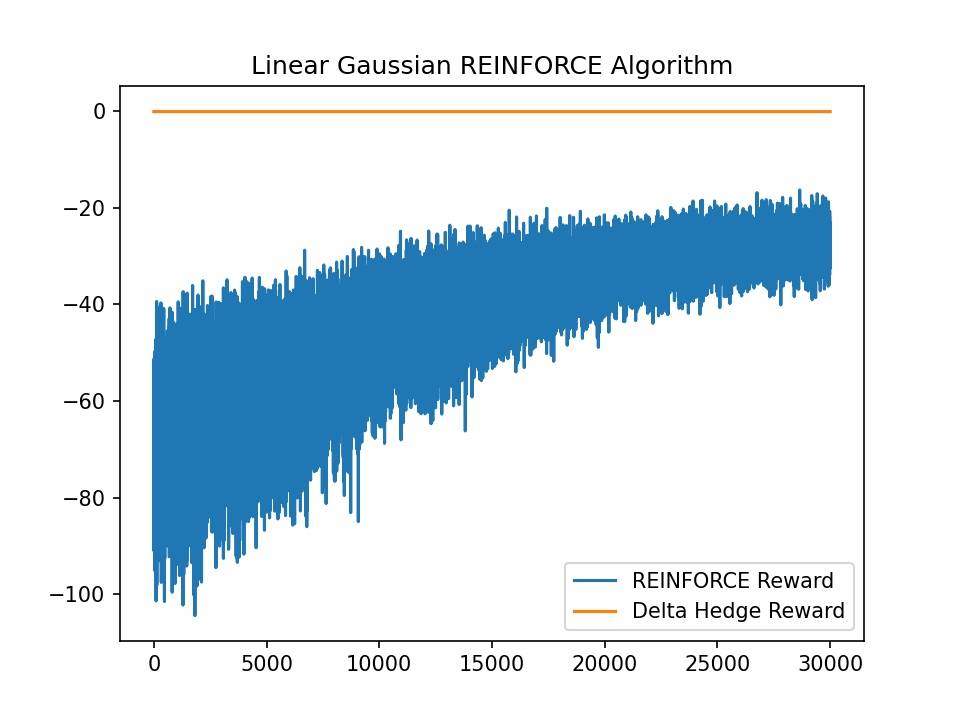

In [5]:
REINFORCE()

Next I derive the REINFORCE Algorithm with baseline. I use the dot product of beta and state features as the state value function.

In [6]:
class REINFORCE_Baseline_agent(REINFORCE_agent):
    def __init__(self, n, T, volatility, r, initial_price, alpha, training_time, beta):
        super().__init__(n, T, volatility, r, initial_price, alpha, training_time)
        self.w = np.zeros(3)
        self.beta = beta
    
    def reset(self):
        self.w = np.zeros(3)
        self.theta = np.zeros(6)
    
    def train(self):
        reward_history = []
        delta_reward_history = []
        for i in range(self.training_time):
            temp_state, temp_action, temp_reward, temp_param, temp_delta_reward = self.generate_episode()
            
            # calculate state value
            G = np.zeros(len(temp_state))
            G[-1] = temp_reward[-1]
            
            for j in range(2, len(temp_state) + 1):
                G[-j] = self.discount*G[-j + 1] + temp_reward[-j]
            
            # calculate delta hedge total reward
            delta_G = np.zeros(len(temp_state))
            delta_G[-1] = temp_delta_reward[-1]
            
            for j in range(2, len(temp_state) + 1):
                delta_G[-j] = self.discount*delta_G[-j + 1] + temp_delta_reward[-j]
            
            # update theta and w according to REINFORCE Algorithm with Baseline
            multiple = 1
            for j in range(len(temp_state)):
                
                small_delta = G[j] - self.w @ self.state_feature[temp_state[j]]
                
                # update theta
                delta = np.zeros(6)
                middle_point = 3
                delta[:middle_point] = (temp_action[j] - temp_param[j][0])*self.state_feature[temp_state[j]]/temp_param[j][1]**2
                delta[middle_point:] = ((temp_action[j] - temp_param[j][0])**2/temp_param[j][1]**2 - 1)*self.state_feature[temp_state[j]]
                update = self.alpha*multiple*small_delta*delta
                self.theta += update
                
                # update w
                self.w += self.beta*multiple*small_delta*np.ones(3)
                multiple = multiple*self.discount

            reward_history.append(G[0])
            delta_reward_history.append(delta_G[0])
        return reward_history, delta_reward_history

In [7]:
def REINFORCE_baseline():
    n = 50
    T = 1
    volatility = 0.1
    r = 0.02
    initial_price = 100
    alpha = 1e-9
    beta = 1e-8
    training_time = 30000
    model = REINFORCE_Baseline_agent(n, T, volatility, r, initial_price, alpha, training_time, beta)
    model.data_generate()
    model.construct_state_feature()
    reward_history, delta_reward_history = model.train()
    reward_history = pd.DataFrame({'REINFORCE Reward':reward_history, 'Delta Hedge Reward': delta_reward_history})
    reward_history.plot(title = 'Linear Gaussian REINFORCE Algorithm with Baseline')
    plt.show()

<IPython.core.display.Javascript object>


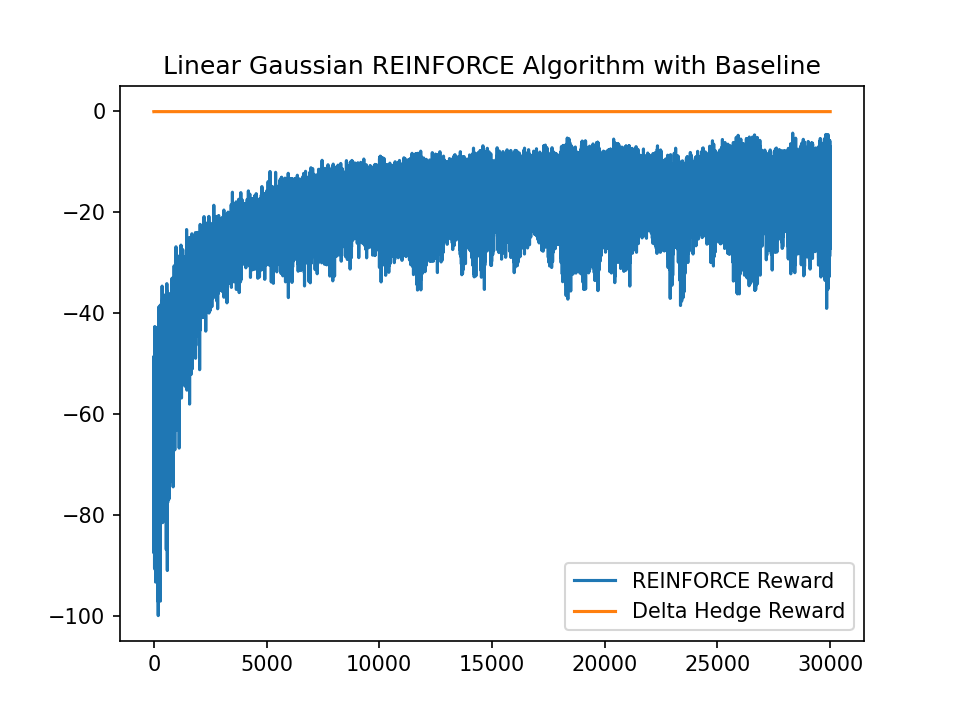

In [8]:
REINFORCE_baseline()

It seems that the REINFORCE with Baseline algorithm performs slightly better than the original REINFORCE algorithm.

In [9]:
class Actor_Critic_Eligible_trace_agent(REINFORCE_Baseline_agent):
    def __init__(self, n, T, volatility, r, initial_price, alpha, training_time, beta, eta, lambda_w, lambda_theta):
        super().__init__(n, T, volatility, r, initial_price, alpha, training_time, beta)
        self.z_w = np.zeros(3)
        self.z_theta = np.zeros(6)
        self.average_R = 0
        self.eta = eta
        self.lambda_w = lambda_w
        self.lambda_theta = lambda_theta

    def reset(self):
        self.theta = np.zeros(6)
        self.w = np.zeros(3)
        self.z_theta = np.zeros(6)
        self.z_w = np.zeros(3)        
        self.average_R = 0
        
    def train(self):
        reward_history = []
        delta_reward_history = []
        
        for i in range(self.training_time):
            j = 1
            k = 0
            state = [j, k]
            temp_rewards = []
            temp_delta_rewards = []
            while j < self.n:
                temp_state = tuple(state)
                temp_state_feature = self.state_feature[temp_state]
                
                # choose action
                middle_point = 3
                mu = self.theta[:middle_point] @ temp_state_feature
                sigma = np.exp(self.theta[middle_point:] @ temp_state_feature)
                temp_action = np.random.normal(mu, sigma)
            
                # calculate delta
                if j == 1:
                    delta = -0.5
                else:
                    delta = -(self.option_price[(j + 1, k)] - self.option_price[(j + 1, k + 1)])/(self.stock_price[(j + 1, k)][0] - self.stock_price[(j + 1, k + 1)][0])
            
                # Calculate the next state
                j += 1
                temp_p = random.random()
                if temp_p > self.p:
                    k += 1

                temp_next_state = [j,k]

                # calculate the reward
                temp_reward = self.get_reward(temp_state, tuple(temp_next_state), temp_action)
                temp_delta_reward = self.get_reward(temp_state, tuple(temp_next_state), delta)
                
                # update theta and w according to Actor-Critic with Eligibility Traces
                if j == self.n:
                    next_state_value = 0
                else:
                    next_state_value = self.w @ self.state_feature[tuple(temp_next_state)]
                small_delta = temp_reward - self.average_R + (next_state_value - self.w @ self.state_feature[temp_state])
                
                self.average_R += self.eta*small_delta
                
                # update theta
                delta = np.zeros(6)
                middle_point = 3
                delta[:middle_point] = (temp_action - mu)*self.state_feature[temp_state]/sigma**2
                delta[middle_point:] = ((temp_action - mu)**2/sigma**2 - 1)*self.state_feature[temp_state]
                
                self.z_theta = self.lambda_theta*self.z_theta + delta
                update = self.alpha*small_delta*self.z_theta
                self.theta += update
                
                # update w
                self.z_w = self.lambda_w*self.z_w + np.ones(3)
                self.w += self.beta*small_delta*self.z_w
                
                # update episode reward
                temp_rewards.append(temp_reward)
                temp_delta_rewards.append(temp_delta_reward)
                state = temp_next_state
            
            # update reward
            G = np.zeros(len(temp_rewards))
            G[-1] = temp_rewards[-1]
            
            for j in range(2, len(temp_rewards) + 1):
                G[-j] = self.discount*G[-j + 1] + temp_rewards[-j]
            
            
            # calculate delta hedge total reward
            delta_G = np.zeros(len(temp_delta_rewards))
            delta_G[-1] = temp_delta_rewards[-1]
            
            for j in range(2, len(temp_delta_rewards) + 1):
                delta_G[-j] = self.discount*delta_G[-j + 1] + temp_delta_rewards[-j]
            
            reward_history.append(G[0])
            delta_reward_history.append(delta_G[0])
            
        return reward_history, delta_reward_history    
    
    

In [16]:
def Actor_Critic_Eligible_trace():
    n = 50
    T = 1
    volatility = 0.1
    r = 0.02
    initial_price = 100
    alpha = 3e-9
    beta = 1e-9
    training_time = 30000
    eta = 1e-6
    lambda_theta = 0.9
    lambda_w = 0.9
    model = Actor_Critic_Eligible_trace_agent(n, T, volatility, r, initial_price, alpha, training_time, beta, eta, lambda_theta, lambda_w)
    model.data_generate()
    model.construct_state_feature()
    reward_history, delta_reward_history = model.train()
    reward_history = pd.DataFrame({'Actor-Critic Reward':reward_history, 'Delta Hedge Reward': delta_reward_history})
    reward_history.plot(title = 'Actor-Critic with Eligibility Traces')
    plt.show()

<IPython.core.display.Javascript object>


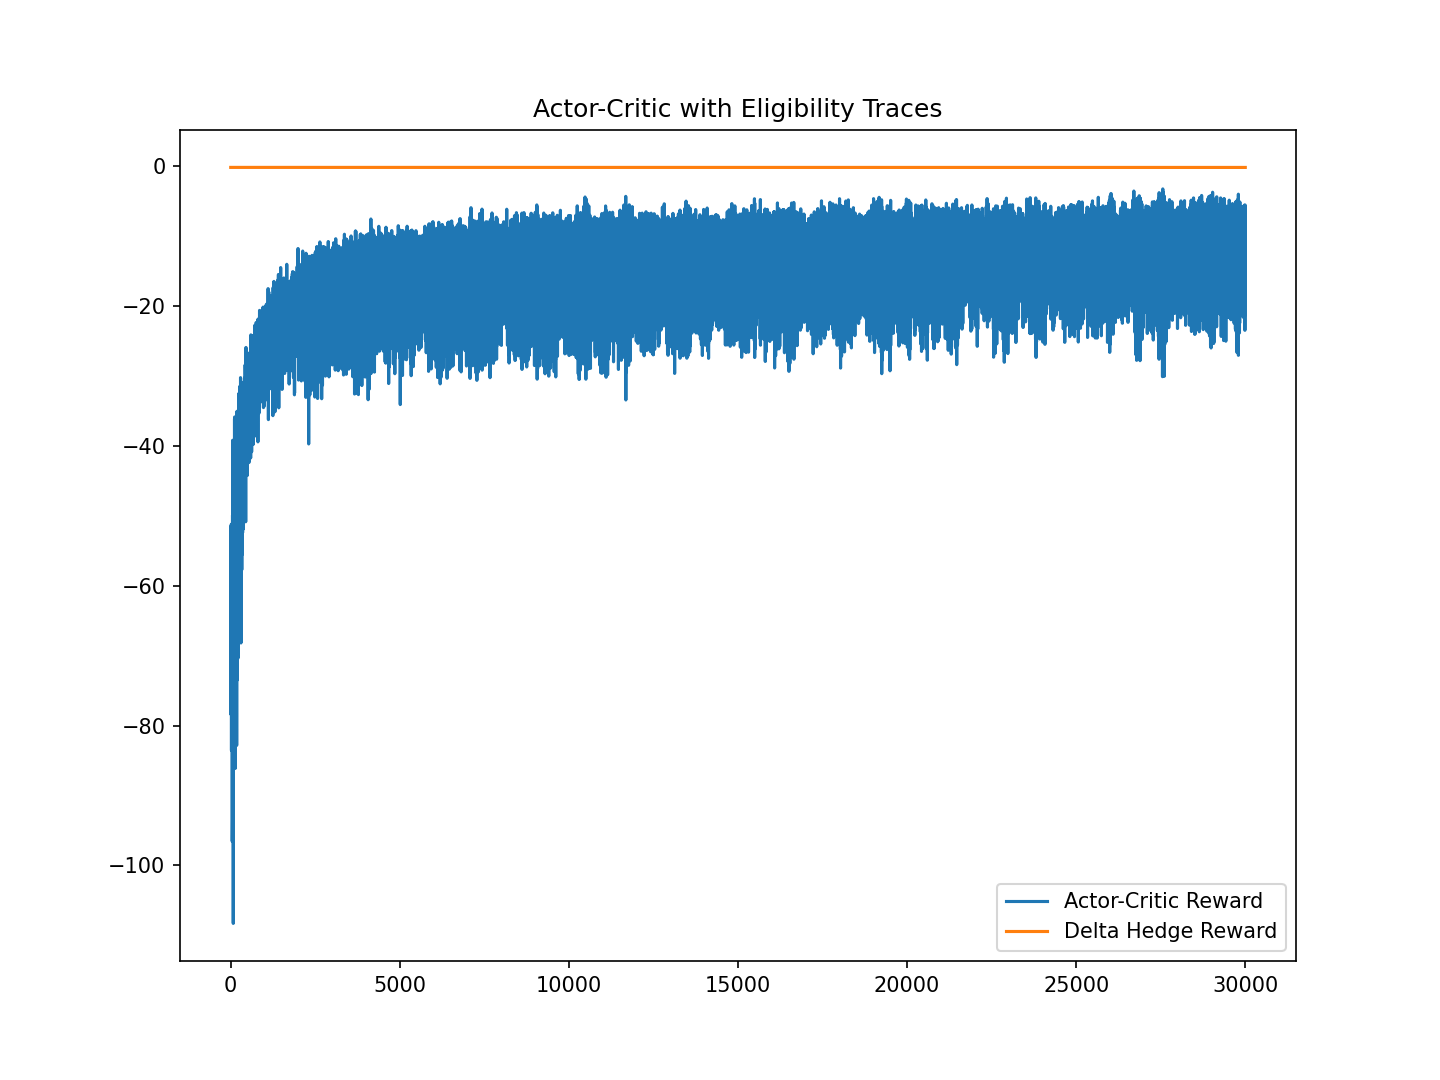

In [17]:
Actor_Critic_Eligible_trace()